# Ellis wormhole

In this example notebook we will go beyond the Schwarzshild space-time and consider a different metric. In particular we will study the Ellis wormhole and the geodesic motion of light rays in it.

Let's start by importing the needed packages:

In [1]:
import pygro
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926c", "#b53546", "#e78b50", "#703676", "#b68ec4", "#37b4b4", "#c8c330"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['axes.unicode_minus']=False

And by defining the metric element.

We will consider the simplest traversable wormhole metric in the Morris-Thorne sense, given by the [line element](https://en.wikipedia.org/wiki/Ellis_wormhole):

$$
    ds^2 = -c^2 dt^2 + dl^2 + (b_0^2+l^2)(d\theta^2+\sin^2\theta d\phi^2)
$$

which uses coordinates ($t$, $l$, $\theta$, $\phi$). We can see from the metric element that $\theta$ and $\phi$ have the usual meaning of angular spherical coordiantes. Surfaces of constant $t$ and $l$ define 2-spheres of aerial radius $r\equiv\sqrt{b_0^2+l^2}$. For $l\to0$ the aerial radius has a non-zero minimum $r=b_0$, which is thus a parameter that determines the size of the so-called *throat* of the metric.

Let's define all this in PyGRO, using the aerial radius for our ``transform_functions`` that we will use for visualization. Initially we will set the value of the thorat parameter to $b_0 = 1$

In [3]:
name = "Morris-Thorne spacetime"
coordinates = ["t", "l", "theta", "phi"]

transform_functions = [
    "t",
    "sqrt(b_0**2+l**2)*sin(theta)*cos(phi)",
    "sqrt(b_0**2+l**2)*sin(theta)*sin(phi)",
    "sqrt(b_0**2+l**2)*cos(theta)"
]


line_element = "-dt**2+dl**2+(b_0**2+l**2)*(dtheta**2+sin(theta)**2*dphi**2)"

metric = pygro.Metric(
    name = name,
    coordinates = coordinates,
    line_element = line_element,
    transform = transform_functions,
    b_0 = 1
)


(PyGRO) INFO: Initializing Morris-Thorne spacetime.
(PyGRO) INFO: Calculating inverse metric.
(PyGRO) INFO: Calculating symbolic equations of motion.
(PyGRO) INFO: Computing helper functions to normalize 4-velocity.
(PyGRO) INFO: The Metric (Morris-Thorne spacetime) has been initialized.


Now we can link the metric to a ``GeodesicEngine`` and we can set no stopping criterion, since the metric is devoid of horizons.

In [4]:
geo_engine = pygro.GeodesicEngine(metric)

(PyGRO) INFO: Linking Morris-Thorne spacetime to the Geodesic Engine
(PyGRO) INFO: Metric linking complete.


We are now going to start to play around with light-rays (null geodesics) in this space-time. 

Let's do this using the ``Observer`` class. In particular, we will use a very simple co-frame identifying stationary observers in the Ellis metric:

\begin{align}
    \sigma_0&=dt,& \sigma_1 &= -dl\\
    \sigma_2&=\sqrt(b_0^2+l^2)\sin\theta d\phi,& \sigma_3&=-\sqrt(b_0^2+l^2)d\theta\\
\end{align}

which identifies stationary observers with the $f_1$ frame vector pointed in the radial direction, the $f_2$ vector pointed tangentially to the angular 2-spheres in the azimuthal direction and $f_3$ perpendicular to $f_1$ and $f_2$, in the latitudinal direction.

We will initially fix the observer on the throat:

In [5]:
observer = pygro.Observer(
    metric,
    [0, 0, np.pi/2, 0],
    coframe = [
        "dt",
        "-dl",
        "sqrt(b_0**2+l**2)*sin(theta)*dphi", 
        "-sqrt(b_0**2+l**2)*dtheta"
    ]
)

Let's now move it around and start to fire light rays from it.

In particular we will move the observer on a line that is parallel to the $y$ axis on the equatorial plane ($\theta = \pi/2$ and $\phi = \pi/2$) and fire geodesics towards the wormhole along the $x$ axis.

We can achieve this by considering the following geometrical configuration

![Wormhole geometrical configuration](../_static/wormhole-configuration.png)

We can thus fix a given value of $\hat{x}$ define an array of $\hat{y}$ from which we want to fire the photon. We can compute the corresponding value of $\phi$, move the observer at the location ($l=\sqrt{\hat{x}^2+\hat{y}^2, \phi = \phi}$) and fire a geodesic parallel to the $x$ axis, *i.e.* forming an angle $\phi$ from the direciton of $\vec{f}_1$. We will do this by using the ``from_f1`` method of the ``Observer`` class.

This is implemented here:

In [6]:
y_arr = np.linspace(-5, 5, 81)
 
geo_arr = []

for y in y_arr:
    
    x = 10
    phi = np.arctan(y/x)
    
    observer.x = [0, np.sqrt(x**2+y**2), np.pi/2, phi]
    
    geo = pygro.Geodesic("null", geo_engine, verbose = False)
    geo.initial_x = observer.x
    geo.initial_u = observer.from_f1(0, phi, type = geo.type)
    
    # We limit the step size for the radial geodesic
    geo_engine.integrate(geo, 100, 0.0001, verbose = False, accuracy_goal = 16, precision_goal = 16, hmax =  0.01 if y == 0 else 1) 

    geo_arr.append(geo)

Let's now visualize the results. 

We will check for each geodesic that it has traversed the throat, namely that there exist values of $l<0$ in the integrated array of positions. In that case we will color the geodesic blue.

Moreover, we will split the visualization in the two universes, one for $l>0$ the other for $l<0$. To do this we will identify the values of the geodesic that fall in the first universe and plot them on the left axis, while we will plot on the right one the values that fall in the other universe.

This is how we implement this:

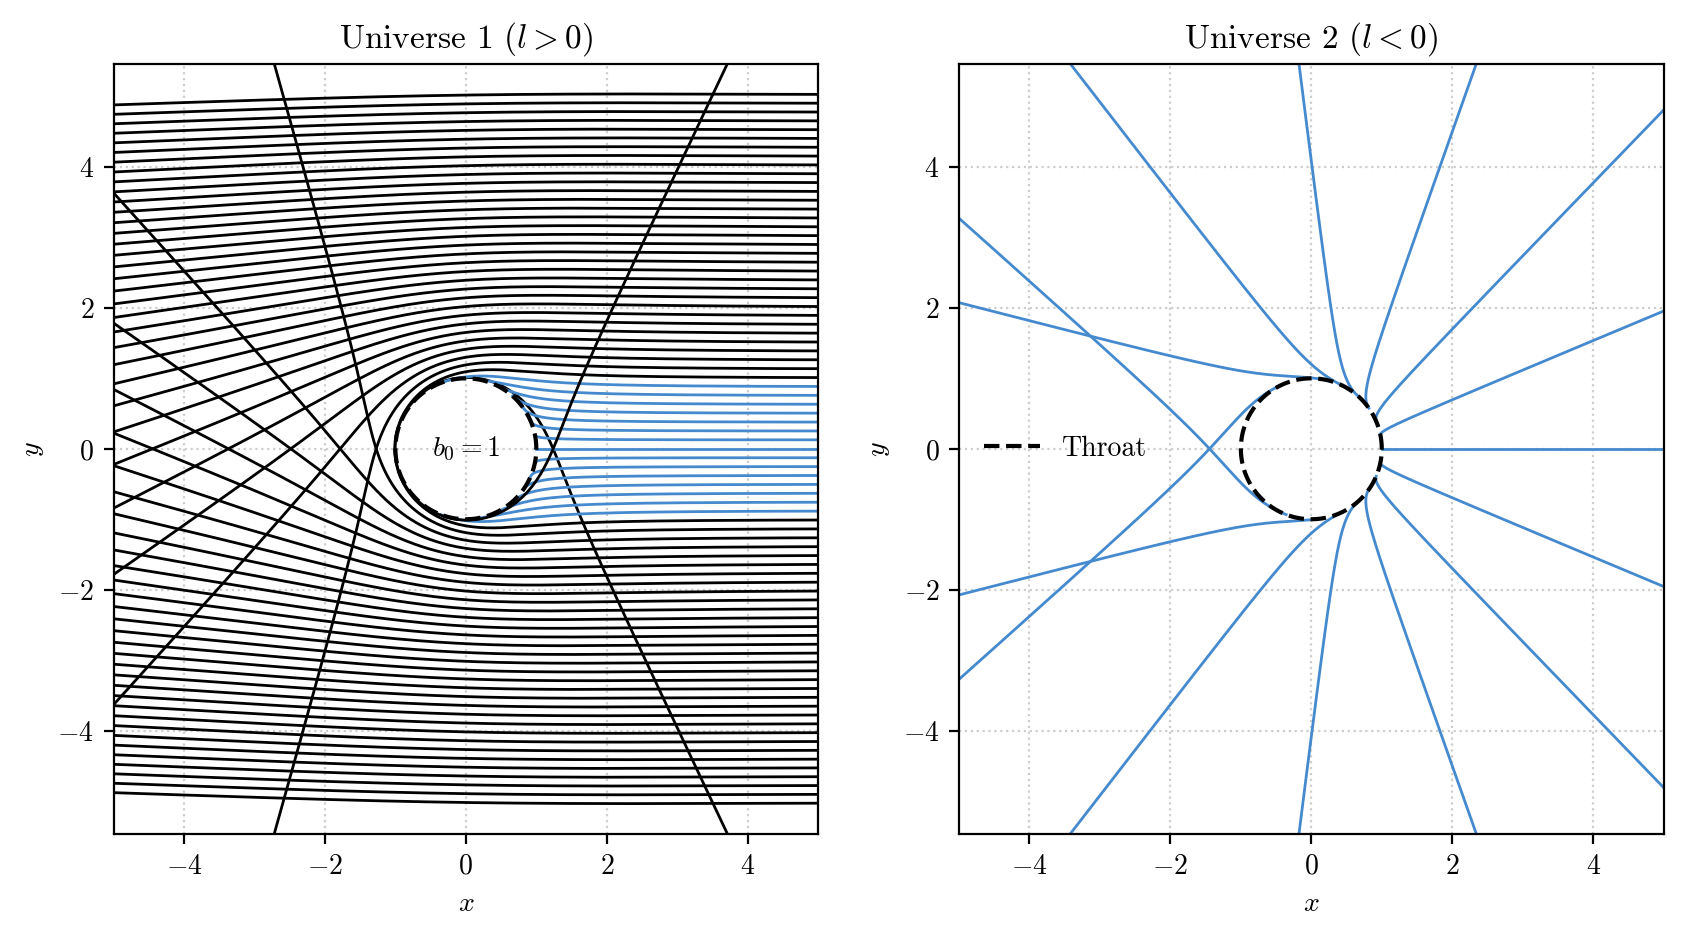

In [7]:
fig, [ax_l, ax_r] = plt.subplots(1, 2, figsize = (10, 5))


for geo in geo_arr:
    t, x, y, z = metric.transform(geo.x.T)
    
    idx = np.argwhere(geo.x[:,1] >= 0)
    
    if np.any(geo.x[:,1] < 0):
        color = "#458ace"
    else:
        color = "k"
    
    ax_l.plot(
        x[idx], y[idx],
        color = color,
        linewidth = 1
    )
    
    idx = np.argwhere(geo.x[:,1] < 0)
    
    ax_r.plot(
        x[idx], y[idx],
        color = color,
        linewidth = 1
    )

theta = np.linspace(0, 2*np.pi, 150)
x_wh = metric.get_constant('b_0')*np.cos(theta)
y_wh = metric.get_constant('b_0')*np.sin(theta)

lim = 5

for ax in [ax_l, ax_r]:
    
    ax.axis('equal')
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    ax.set_axisbelow(True)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    ax.plot(x_wh, y_wh, color = "k", zorder = 100, label = "Throat", linestyle = "--")
    
ax_l.set_title(r"Universe 1 ($l > 0$)")
ax_r.set_title(r"Universe 2 ($l < 0$)")

ax_r.legend()
ax_l.text(0, 0, fr"$b_0 = {metric.get_constant('b_0')}$", ha = "center", va = "center")

plt.show()

We can now play around and see how the picture changes if we change the value of $b_0$. For example run the following cell and then go back to running the previous two cells to see how the result changes

In [8]:
metric.set_constant(b_0 = 2)